Install:
pip install torch==2.3.0 torchtext=0.17.0 --index-url https://download.pytorch.org/whl/cu121


cloned from https://github.com/bentrevett/pytorch-seq2seq?tab=readme-ov-file


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import spacy
import datasets
import torchtext  
import tqdm
import evaluate  #MJ: for bleu = evaluate.load("bleu")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
print(torch.__version__)
print(datasets.__version__)

2.2.0+cu121
3.0.0


In [5]:
print(torch.cuda.is_available())  # Should return True

True


torchtext has an extension module written in C++, which is compiled against specific PyTorch binary distribution. This means that running torchtext requires the matching PyTorch binary distribution.
If installing an official binary distribution of torchtext, please make sure that the combination of pytorch and torchtext is one that is listed in README. https://github.com/pytorch/text#installation

If you are using PyTorch built and maintained by unofficial source, such as pytorch-opt-cuda, torchtext official release is not expected to work. Please ask the maintainers of such source to publish the matching torchtext: 2.3.0	0.18.0; When using pip, PyTorch handles CUDA differently. By default, when you run pip install torch, it downloads pre-built binaries that include both the PyTorch code and the appropriate CUDA version bundled inside (e.g., torch==2.3.0+cu118 includes CUDA 11.8). This makes it unnecessary to install pytorch-cuda separately when using pip.

In contrast, Conda separates the installation of PyTorch and the CUDA toolkit, allowing you to specify and manage CUDA versions independently (e.g., with pytorch-cuda=11.8). This approach gives more flexibility.

This is my GPU:
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2  
pip install torch==2.3.0 --index-url https://download.pytorch.org/whl/cu122
==>t PyTorch 2.3.0 is not yet available or hasn't been released for CUDA 12.2. 
pip install torch==2.2.0 torchtext==0.17.0 --index-url https://download.pytorch.org/whl/cu121

In [3]:

#

In [2]:
print(torchtext.__version__)
#pip install torchtext --index-url https://download.pytorch.org/whl/cu121 => This will attempt to install a CUDA-enabled version of torchtext for CUDA 12.1

0.17.0+cpu


In [43]:
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# You can visit the Multi30k dataset on Hugging Face through the following link: Multi30k on Hugging Face.
# https://huggingface.co/datasets/bentrevett/multi30k
# This dataset is designed for translation tasks, specifically for English-to-German translations, 
# and includes three data splits: training (29,000 examples), validation (1,014 examples),
# and test (1,000 examples). It contains both English (en) and German (de) sentences, 
# with the goal of translating between the two languages

In [44]:
dataset = datasets.load_dataset("bentrevett/multi30k")
# The "30K" in Multi30k refers to the fact that the dataset originally contained around 30,000 image-caption pairs. 
# The Multi30k dataset was developed for multilingual captioning and translation tasks 
# and is built upon the Flickr30k dataset, which has 30,000 images, each with multiple captions.

# Key Points:
# Flickr30k: The Multi30k dataset is based on the Flickr30k dataset, which contains 30,000 images 
# with captions in English.
# Multi30k: The "multi" part of Multi30k refers to the addition of multilingual captions
# and translations in German, French, Czech, and other languages for these 30,000 images.

In [8]:
type(dataset)

datasets.dataset_dict.DatasetDict

In [45]:
train_data, valid_data, test_data = (
    dataset["train"],
    dataset["validation"],
    dataset["test"],
)

In [5]:
train_data
#Tokenization: Converts a sentence like "hello world" into ['hello', 'world'].
#Indexing: Maps each token to an index using a vocabulary, e.g., {'hello': 1, 'world': 2}, resulting in [1, 2].

Dataset({
    features: ['en', 'de'],
    num_rows: 29000
})

Features of en_core_web_sm:
Part-of-Speech Tagging (POS): It assigns POS tags to each word in the text, indicating its syntactic function (e.g., noun, verb, adjective).
Dependency Parsing: It determines the grammatical relationships between words in a sentence (e.g., subject, object).
Named Entity Recognition (NER): It identifies named entities in text, such as people, organizations, locations, and dates.
Lemmatization: It reduces words to their base or dictionary form (e.g., "running" → "run").
Tokenization: It breaks down the text into tokens (words, punctuation, etc.)

In [7]:
# Get the file path to the installed 'de_core_news_sm' model
model_path = spacy.util.get_package_path("de_core_news_sm")
print(model_path)

/home/yeol/anaconda3/envs/Seq2SeqAttn/lib/python3.10/site-packages/de_core_news_sm


In [46]:
en_nlp = spacy.load("en_core_web_sm")  #en_core_web_sm is a small-sized pretrained language model provided by spaCy for processing English text.
de_nlp = spacy.load("de_core_news_sm")  #he model is installed as a Python package in your environment. cf. path  = spacy.util.get_package_path("de_core_news_sm")

In [47]:
def tokenize_example(example, en_nlp, de_nlp, max_length, lower, sos_token, eos_token): #MJ: max_length = 1_000
    all_en_tokens = [ token.text for token in en_nlp.tokenizer(example["en"]) ]
    all_de_tokens = [ token.text for token in de_nlp.tokenizer(example["de"]) ]
    en_tokens = all_en_tokens[:max_length]
    de_tokens = all_de_tokens[:max_length]
    
    # If max_length is greater than the actual length of all_en_tokens (or all_de_tokens), the slicing operation:
    #  en_tokens = all_en_tokens[:max_length]
    #  de_tokens = all_de_tokens[:max_length]
    # will not cause any error and will simply return the entire list of tokens without truncation
    #Note that train_data = 
    # # Dataset({
    #     features: ['en', 'de'],
    #     num_rows: 29000
    # })
    # en_tokens = [ token.text for token in en_nlp.tokenizer(example["en"]) ][:max_length]
    # de_tokens = [ token.text for token in de_nlp.tokenizer(example["de"]) ][:max_length]
    
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        de_tokens = [token.lower() for token in de_tokens]
        
    en_tokens = [sos_token] + en_tokens + [eos_token]
    de_tokens = [sos_token] + de_tokens + [eos_token]
    return {"en_tokens": en_tokens, "de_tokens": de_tokens}

In [11]:
train_data[0]
# Even though individual examples are dictionary-like, train_data itself is a dataset object that 
# supports additional methods for efficient data processing and loading (like .map(), .filter(), etc.).

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'en_tokens': ['<sos>',
  'two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.',
  '<eos>'],
 'de_tokens': ['<sos>',
  'zwei',
  'junge',
  'weiße',
  'männer',
  'sind',
  'im',
  'freien',
  'in',
  'der',
  'nähe',
  'vieler',
  'büsche',
  '.',
  '<eos>']}

In [48]:
max_length = 1_000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,
    "de_nlp": de_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

#The returned values {"en_tokens": en_tokens, "de_tokens": de_tokens} are added to each example as new columns.
# The .map() function in the Hugging Face datasets library is designed to apply a function to each example in a dataset, and the result of that function can replace, modify, or add new columns.

# If the function you provide to .map() returns new columns, those columns will be added to the dataset.
# If the function returns modified values for existing columns, those columns will be updated.
# If the function returns fewer columns, you can remove columns by specifying them in the return.
# the .map() function in the Hugging Face datasets library can automatically detect whether the function returns an existing column or introduces new columns. It does this by analyzing the keys of the dictionary returned by the function you pass to .map().

#train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs, remove_columns=["en", "de"])

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

Thus, after mapping, each example in train_data will have the original fields "en" and "de" (the original sentences) and new fields "en_tokens" and "de_tokens" (the tokenized versions of the sentences).

So the dataset will now look something like this:
{
    "en": "Two young, White males are outside near many bushes.",
    "de": "Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.",
    "en_tokens": ["<sos>", "two", "young", "white", "males", "are", "outside", "near", "many", "bushes", ".", "<eos>"],
    "de_tokens": ["<sos>", "zwei", "junge", "weiße", "männer", "sind", "im", "freien", "in", "der", "nähe", "vieler", "büsche", ".", "<eos>"]
}

In [12]:
train_data[0]


{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'en_tokens': ['<sos>',
  'two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.',
  '<eos>'],
 'de_tokens': ['<sos>',
  'zwei',
  'junge',
  'weiße',
  'männer',
  'sind',
  'im',
  'freien',
  'in',
  'der',
  'nähe',
  'vieler',
  'büsche',
  '.',
  '<eos>']}

In [49]:
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

from torchtext.vocab import build_vocab_from_iterator
# en_vocab = torchtext.vocab.build_vocab_from_iterator(
#     train_data["en_tokens"],
#     min_freq=min_freq,
#     specials=special_tokens,
# )

# de_vocab = torchtext.vocab.build_vocab_from_iterator(
#     train_data["de_tokens"],
#     min_freq=min_freq,
#     specials=special_tokens,
# )

#MJ: the vocab functionality is no longer included under the main torchtext namespace;
# To use torchtext.vocab.build_vocab_from_iterator as torchtext.vocab.build_vocab_from_iterator,
# the torchtext library would need to be structured such that the vocab module is exposed as part of the top-level namespace. This means that the vocab module would need to be accessible directly from the torchtext package without the need for additional imports.

# For example, in torchtext/__init__.py, there should be a line like:
# from .vocab import build_vocab_from_iterator
# Instead, you must explicitly import it from the specific submodule torchtext.vocab.

en_vocab = build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

de_vocab = build_vocab_from_iterator(
    train_data["de_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [50]:
assert en_vocab[unk_token] == de_vocab[unk_token]
assert en_vocab[pad_token] == de_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

In [15]:
for idx, token in enumerate(en_vocab.get_itos()):
    print(f"Index {idx}: {token}")

Index 0: <unk>
Index 1: <pad>
Index 2: <sos>
Index 3: <eos>
Index 4: a
Index 5: .
Index 6: in
Index 7: the
Index 8: on
Index 9: man
Index 10: is
Index 11: and
Index 12: of
Index 13: with
Index 14: woman
Index 15: ,
Index 16: two
Index 17: are
Index 18: to
Index 19: people
Index 20: at
Index 21: an
Index 22: wearing
Index 23: shirt
Index 24: young
Index 25: white
Index 26: black
Index 27: his
Index 28: while
Index 29: blue
Index 30: men
Index 31: red
Index 32: sitting
Index 33: girl
Index 34: boy
Index 35: dog
Index 36: standing
Index 37: playing
Index 38: group
Index 39: street
Index 40: down
Index 41: walking
Index 42: -
Index 43: front
Index 44: her
Index 45: holding
Index 46: one
Index 47: water
Index 48: three
Index 49: by
Index 50: women
Index 51: up
Index 52: green
Index 53: little
Index 54: for
Index 55: child
Index 56: looking
Index 57: outside
Index 58: as
Index 59: large
Index 60: through
Index 61: brown
Index 62: yellow
Index 63: children
Index 64: person
Index 65: from
Inde

In [51]:
en_vocab.set_default_index(unk_index) 
de_vocab.set_default_index(unk_index)
# calling en_vocab.set_default_index(unk_index) changes the behavior of the en_vocab object
# by modifying how it handles out-of-vocabulary (OOV) tokens. 
# Specifically, it ensures that when you attempt to access a token that is not in the vocabulary, 
# it will return the unk_index instead of raising an error or returning None.

In [17]:
input_dim = len(de_vocab)
output_dim = len(en_vocab)
print('vocab size of DE=', input_dim)
print('vocab size of EN=', output_dim)

vocab size of DE= 7853
vocab size of EN= 5893


In [52]:
def numericalize_example(example, en_vocab, de_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    return {"en_ids": en_ids, "de_ids": de_ids}

In [53]:
fn_kwargs = {"en_vocab": en_vocab, "de_vocab": de_vocab}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

In [20]:
len(train_data)

29000

In [20]:
train_data[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'en_tokens': ['<sos>',
  'two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.',
  '<eos>'],
 'de_tokens': ['<sos>',
  'zwei',
  'junge',
  'weiße',
  'männer',
  'sind',
  'im',
  'freien',
  'in',
  'der',
  'nähe',
  'vieler',
  'büsche',
  '.',
  '<eos>'],
 'en_ids': [2, 16, 24, 15, 25, 778, 17, 57, 80, 202, 1312, 5, 3],
 'de_ids': [2, 18, 26, 253, 30, 84, 20, 88, 7, 15, 110, 7647, 3171, 4, 3]}

In [54]:
data_type = "torch"
format_columns = ["en_ids", "de_ids"]
#MJ: This means that both en_ids and de_ids will be returned as PyTorch TENSORS. 
# If there are any other columns in the dataset, they will still be included in the output without conversion, 
# as the output_all_columns=True flag ensures all columns are retained.   

train_data = train_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

valid_data = valid_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

In [25]:
train_data[0]

{'en_ids': tensor([   2,   16,   24,   15,   25,  778,   17,   57,   80,  202, 1312,    5,
            3]),
 'de_ids': tensor([   2,   18,   26,  253,   30,   84,   20,   88,    7,   15,  110, 7647,
         3171,    4,    3]),
 'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'en_tokens': ['<sos>',
  'two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.',
  '<eos>'],
 'de_tokens': ['<sos>',
  'zwei',
  'junge',
  'weiße',
  'männer',
  'sind',
  'im',
  'freien',
  'in',
  'der',
  'nähe',
  'vieler',
  'büsche',
  '.',
  '<eos>']}

In [55]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]  #MJ: len(batch_en_ids)=128; len(batch_en_ids[0]) = 17
        batch_de_ids = [example["de_ids"] for example in batch]
        
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        #MJ: https://github.com/pfnet/pfrl/issues/154: 
#         File "/home/aurelien/.local/lib/python3.8/site-packages/torch/nn/utils/rnn.py", line 363, in pad_sequence
# return torch._C._nn.pad_sequence(sequences, batch_first, padding_value) TypeError: pad_sequence(): argument 'sequences' (position 1) must be tuple of Tensors, not Tensor

        batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "de_ids": batch_de_ids,
        }
        return batch

    return collate_fn

In [56]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index) #MJ: add padding indices
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [57]:
batch_size = 128
#pad_index = en_vocab[pad_token] == the pad token index
train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [58]:
class Encoder(nn.Module):
    def __init__(
        self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout
    ):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim) #In the paper, E in R^{embedding_dim x input_dim } = R^{m xK}
        #MJ: we only use a single layer GRU, however we now use a bidirectional RNN
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional=True) #MJ: for decoder: self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim)
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        self.dropout = nn.Dropout(dropout)
        
        #GRU: Unlike a traditional deep neural network, which uses different parameters at each layer, a RNN shares the same parameters
        # U,V,W across all steps. This reflects the fact that we are performing the same task at each step, just with different inputs. 
        
        # h_{t+1} = z_{t+1} \circ h_t + (1 - z_{t+1}) \circ \tilde{h}_{t+1}
        # z_{t+1} = \sigma\left(W_z^{\text{enc}} E(X_{t+1}) + U_z^{\text{enc}} h_t\right)
        # r_{t+1} = \sigma\left(W_r^{\text{enc}} E(X_{t+1}) + U_r^{\text{enc}} h_t\right)
        # \tilde{h}_{t+1} = \tanh\left(W_h^{\text{enc}} E(X_{t+1}) + r_{t+1} \circ U_h^{\text{enc}} h_t\right)
        
        # outputs = [h_1,h2,...,h_T]
        # hidden = h_T



#MJ: RNN:https://dennybritz.com/posts/wildml/recurrent-neural-networks-tutorial-part-1/
#    https://dennybritz.com/posts/wildml/recurrent-neural-networks-tutorial-part-2/
# BPTT: https://dennybritz.com/posts/wildml/recurrent-neural-networks-tutorial-part-3/
#==> https://github.com/dennybritz/rnn-tutorial-rnnlm


    def forward(self, src):
        # src = [src length, batch size]: [27,128]; src[0] = a batch of <sos>; src[26]=<eos>
        embedded = self.dropout(self.embedding(src)) #MJ:  The dropout layer is applied to the output of the embedding layer. Dropout randomly sets 30% of the elements in the embedded tensor to zero during training. The resulting tensor (embedded) has the same shape as the input: [29, 128, 256].
        # embedded = [src length, batch size, embedding dim];MJ:MJ: the goal of dropout is to reduce reliance on specific dimensions of the embedding vector during training 
        outputs, hidden = self.rnn(embedded)  #outputs:[27,128,1024], hidden; [27,128,512], encoder_hidden_dim = 512
        # outputs = [src length, batch size, hidden dim * n directions], n directions=2; MJ: outputs = H
        # hidden = [n layers * n directions, batch size, hidden dim], MJ: containing the FINAL hidden state (h_T)  for the input sequence.
        # hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        # outputs are always from the last layer [in our case, there is only one layer]
        # hidden [-2, :, : ] is the last of the forwards RNN; MJ: hidden[-2,:,:] == hidden[0] = one vector for each src seq in the batch
        # hidden [-1, :, : ] is the last of the backwards RNN; MJ: hidden[-1,:,:] = hidden[1]
        # The initial decoder hidden, s_0, is final hidden state, h_T,  of the forwards and backwards
        # encoder RNNs FED through a linear layer, self.fc: his is actually a deviation from the paper. Instead, they feed only the first backward RNN hidden state through a linear layer to get the context vector/decoder initial hidden state. This doesn't seem to make sense to me, so we have changed it.
        hidden_s0 = torch.tanh(
            self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        )
        #MJ: z = s_0 = tanh( g(h^{->}_T, h^{<-}_T)) <==> The initial hidden state s0 is computed by s0 = tanh (Ws h^{<-}_T ) in the paper.
      
        
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        return outputs, hidden_s0

In [59]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        
        # From paper: a( s_{i-1}, h_j) = v_a^T * tanh( W_a*s_{i-1} + U_a*h_j)
        # h_1 = [h_1^{arrowforward}; h_T^{arrowback}]; H = [h_1,..,h_T]
        #W_a*s_{i-1} + U_a*h_j:  The dim of h_j =  encoder_hidden_dim * 2: 
        #    This code implements this attenion by a simpler  A*[s_{i-1};h_j] + b
        #  => The same parameter matrix A and bias b are applied to all the locations in the sequence 
        self.attn_fc = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim, decoder_hidden_dim
        )
        #MJ: Shape: torch.Size([1024, 3072]), Num of Parameters: 1024 * 3072 = 3,145,728
        
        #v_a^T * self.attn_fc(s_{i-1};h_j )
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden = [batch size, decoder hidden dim]
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]
        
        # REPEAT decoder hidden state src_length times: FOr given i (in decoder), compute alpha_{ij}, for all j (in encoder)
        # c_i = alpha_{ij} * h_j => Do not repeat it for each i, but compute the attention matrix A in vectorized computation
        # hidden = [batch size, decoder hidden dim]
        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1)  #hidden = s_i: All these "copies" share the same underlying memory, meaning they reference the same variable. As a result, any gradient calculated with respect to one of these "copies" also applies to the original s_i
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # hidden = [batch size, src length, decoder hidden dim]
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        #E_t = tanh( attn(s_{t-1}, H))
        #MJ: tanh: to map input values to a range between -1 and 1: RELU will perform better on many problems but not all problems.
        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2)))
        # energy = [batch size, src length, decoder hidden dim]
        
        # a^_t = v^T * E_t
        attention = self.v_fc(energy).squeeze(2)  # self.v_fc(energy): [batch,src length, 1]
        # attention = [batch size, src length]
        #a_t = softmax(a^_t): compute the attention weights
        return torch.softmax(attention, dim=1)

The loop version of Attention:
def forward(self, hidden, encoder_outputs):
        # hidden = [batch size, decoder hidden dim] (s_i)
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2] (h_j's)

        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]

        # Initialize an empty list for storing attention energies
        energies = []

        # Loop over each source token h_j
        for j in range(src_length):
            h_j = encoder_outputs[j]  # [batch size, encoder hidden dim * 2]
            combined = torch.cat((hidden, h_j), dim=1)  # Combine s_i and h_j: [batch size, hidden dim * 3]
            energy = torch.tanh(self.attn_fc(combined))  # [batch size, hidden dim]
            energy = self.energy_fc(energy)  # [batch size, 1]
            energies.append(energy)

        # Convert list of energies into a tensor [batch size, src length]
        energies = torch.cat(energies, dim=1)  # [batch size, src length]

        return torch.softmax(energies, dim=1)  # Softmax to get attention weights

        #The vectorized version
        In this version, instead of looping over each source token h_j,  we repeat the hidden state s_i​
        to match the number of source tokens and compute the attention scores in a single matrix operation:

nn.Linear:
MJ: linear repeats over any batch dimension or sequence of dimensions (for example, batch size or sequence length) and apply the matrix multipication only to the final element n of the input shape.

When you define linear = nn.Linear(m, n) in PyTorch, the nn.Linear layer performs a linear transformation:

𝑦 = 𝑥 * 𝑊^{T} + 𝑏

Where:
𝑥  is the input.
W is a learnable weight matrix of shape [𝑛,𝑚]

x must have the shape [∗,𝑚], where ∗ can be any batch dimension or sequence of dimensions (for example, batch size or sequence length). The final dimension of the input must match the size 𝑚, which is the number of input features.

Output Shape:
The output tensor 𝑦 will have the shape [∗,𝑛], where n is the number of output features.
        
        

In [60]:
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        embedding_dim,
        encoder_hidden_dim,
        decoder_hidden_dim,
        dropout,
        attention,
    ):
        super().__init__()
        self.output_dim = output_dim
        
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim)
        #MJ: Purpose: The decoder generates one output token at a time by using the hidden state from the previous time step and the current input token (the previous output token).
        # Output = hidden at each time step because the hidden state itself is used to predict the next token.
        # 
        # 
        #Parameter Name: decoder.rnn.weight_ih_l0
        #  Shape: torch.Size([3072, 2560]), 2560 = 1024 *2 + 512
        #MJ: Parameter Name: decoder.rnn.weight_hh_l0
        #       Shape: torch.Size([3072, 1024]), Num of Parameters: 3072 * 1024 = 3,145,728
        
        # o_t = W_o[c_t;s_t;E(y_{t-1}] )] + b_o; cf. eq (4) of the paper: 
        #  exp (y_i^T Wt_i), where t_i = [ max{ t^_{i,1}, t~_{i,2} }, max{ t^_{i,3}, t~_{i,4} }, ... max{  t^_{i,l-1}, t~_{i,l} } ], 
        # t^_{i} = U_o s_{i-1} + V_o Ey_{i-1} + C_o c_i
        self.fc_out = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim, output_dim
        )
        #Parameter Name: decoder.fc_out.weight:[5893, 3 * 1024 + 512,],  output_dim = len(en_vocab)  #5893
        #   Shape: torch.Size([5893, 3584]), Num of Parameters: 5893 * 3584 = 21,120,512
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        # input = [batch size]: y_{t-1}
        # hidden = [batch size, decoder hidden dim]: s_{t}, t=0,T-1
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        input = input.unsqueeze(0) #MJ: The current input TOKEN
        # input = [1, batch size]
        embedded_t = self.dropout(self.embedding(input))
        # embedded = [1, batch size, embedding dim]
        
        a_t = self.attention(hidden, encoder_outputs)  #MJ: hidden = s_i, encoder_outputs = H
        # a = [batch size, src length]
        
        a_t = a_t.unsqueeze(1)
        # a = [batch size, 1, src length]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        #c_t = a_t * H = weighted_t
        weighted_t = torch.bmm(a_t, encoder_outputs) #MJ: c_t = weighted
        # weighted_t = [batch size, 1, encoder hidden dim * 2]
        
        #torch.bmm stands for batch matrix multiplication. It performs matrix multiplication between two batches of matrices, specifically 3D tensors, where each tensor has a shape of (batch_size, n, m) and (batch_size, m, p).
        weighted_t = weighted_t.permute(1, 0, 2)
        # weighted = [1, batch size, encoder hidden dim * 2]
        rnn_input_t = torch.cat((embedded_t, weighted_t), dim=2)
        # rnn_input = [1, batch size, (encoder hidden dim * 2) + embedding dim]
        
        output_t, hidden_t = self.rnn(rnn_input_t, hidden.unsqueeze(0)) #hidden = s_t; s_0 = z = h_T; output= output prob of y_t, eq (4)
        
        
# Decoder GRU:
# Input: The decoder is fed one token at a time during the **training** or inference process. It does not receive the entire sequence at once. 
# Instead, it starts with the initial hidden state (from the encoder) and processes tokens one by one to generate the output token
# for each time step.
# Outputs = Hidden: Since the decoder generates tokens one at a time, the GRU hidden state at each time step is immediately used
# to produce the next token, making the hidden state and the output for that time step essentially the same.
# ==>
# The difference comes from how the GRUs are fed with data, not from the GRU structure itself

        # output = [1, batch size, decoder hid dim * n directions]
        # hidden = [n layers * n directions, batch size, decoder hid dim]
        #  n layers and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, decoder hidden dim]
        # hidden = [1, batch size, decoder hidden dim]
        # this also means that output == hidden [only when the number of layers =1 and the number of direction =1]
        assert (output_t == hidden_t).all()
        
        # In many implementations, the output y_t can be the hidden state h_t.​
        # Or it can be a transformation of the hidden state (e.g., through a linear layer). 
        # In some architectures, the hidden state is used internally (e.g., passed to the next time step),
        #  while the output is passed to the next layer for tasks like prediction.
        embedded_t = embedded_t.squeeze(0)
        output_t = output_t.squeeze(0)
        weighted_t = weighted_t.squeeze(0)
        
        #fc_out = g in eq (4)
        prediction_t = self.fc_out(torch.cat((output_t, weighted_t, embedded_t), dim=1)) #(y_{i-1}, c_i, E(y_{i_1}))
        # prediction = [batch size, output dim]
        return prediction_t, hidden_t.squeeze(0), a_t.squeeze(1)

In [68]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size] =[27, 128]
        # trg = [trg length, batch size] =[27,128]
         
        #MJ:1) Having the sequence length first allows RNNs to process one time step at a time in a more efficient manner 
        # when using batching. PyTorch’s implementation allows parallel computation over batches,
        # while sequentially iterating over the time steps. By keeping the sequence length as the first dimension,
        # it becomes easier for the model to traverse through the time dimension.
        # 2) While the shape [batch size, sequence length] might seem more intuitive for batch processing 
        # in most deep learning models (like in CNNs or feedforward networks),
        # RNNs and sequence models need to maintain this time-step-first structure to handle sequential data efficiently.
       
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        batch_size = src.shape[1]
        trg_length = trg.shape[0] #MJ: = 26
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        
        encoder_outputs, hidden_t = self.encoder(src) #Here, t =0
        
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim] = h_T = z = s_0;  encoder_outputs = H
        # first input to the decoder is the <sos> tokens
        input = trg[0, :]  #MJ:  trg = [trg length, batch size];  # trg[0, :] = [batch size] =y_0 = <sos>
        for t in range(1, trg_length): #MJ: 1 <= t <= trg_length - 1: 
            #MJ:Even in the case of the decoder, the RNN is indeed unfolded, but it happens one step at a time during each token generation.
            
            # insert input TOKEN embedding (Ey(y_{i-1}) ), previous hidden state (s_{i-1})  and all encoder hidden states H
            # receive output tensor (predictions) and new hidden state
            output_t, hidden_t, _ = self.decoder(input, hidden_t, encoder_outputs) #MJ: => return prediction_t, hidden.squeeze(0), a.squeeze(1)
            # MJ:  output_t = [batch size, output dim] for the current token
                 
            # 
            # hidden_t = [n layers, batch size, decoder hidden dim]
            # place prediction in a tensor holding predictions for all tokens
            outputs[t] = output_t   #MJ: outputs[0] was set to zero in line 26
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output_t.argmax(1) #MJ: top1.shape =[128]=[batch_size] = the next token predicted from the previous token
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1  #MJ:  trg[t] can be a padding token <pad>, which is 1 in this code
            # input = [batch size]
        return outputs  #MJ: outputs[0] is undefined.

In [62]:
input_dim = len(de_vocab)  #=7853
output_dim = len(en_vocab)  #5893
# encoder_embedding_dim = 256
# decoder_embedding_dim = 256
encoder_embedding_dim = 512
decoder_embedding_dim = 512
# encoder_hidden_dim = 512
# decoder_hidden_dim = 512
encoder_hidden_dim = 1024
decoder_hidden_dim = 1024
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    encoder_dropout,
)
# (rnn): GRU(2560, 1024): 1024 * 2  + 512 = 2560
decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    decoder_dropout,
    attention,
)

model = Seq2Seq(encoder, decoder, device).to(device)

In [32]:
print("source vocab size=", input_dim )
print("BaseException target vocab size =", output_dim) 

source vocab size= 7853
BaseException target vocab size = 5893


In [43]:
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 512)
    (rnn): GRU(512, 1024, bidirectional=True)
    (fc): Linear(in_features=2048, out_features=1024, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=3072, out_features=1024, bias=True)
      (v_fc): Linear(in_features=1024, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 512)
    (rnn): GRU(2560, 1024)
    (fc_out): Linear(in_features=3584, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [63]:
def init_weights(m):
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 512)
    (rnn): GRU(512, 1024, bidirectional=True)
    (fc): Linear(in_features=2048, out_features=1024, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=3072, out_features=1024, bias=True)
      (v_fc): Linear(in_features=1024, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 512)
    (rnn): GRU(2560, 1024)
    (fc_out): Linear(in_features=3584, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [34]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 53,875,973 trainable parameters


named_parameters(): This method returns a tuple containing both the name of each parameter (which typically indicates the layer and type, such as weight or bias) and the tensor itself. This allows you to know not only the parameter values but also where each parameter belongs in the model architecture.

In [86]:
# Loop over named parameters in the model
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter Name: {name}")
              
        if len(param.shape) == 2:  # Matrix parameter
            num_params = param.shape[0] * param.shape[1]
            print(f"Shape: {param.shape}, Num of Parameters: {param.shape[0]} * {param.shape[1]} = {num_params:,}")
        elif len(param.shape) == 1:  # Bias or vector parameter
            num_params = param.shape[0]
            print(f"Shape: {param.shape}, Num of Parameters: {num_params:,}")
        
        print(f"Parameter Values (tensor): {param}")
        print("=" * 50)  # Separator between different parameters

Parameter Name: encoder.embedding.weight
Shape: torch.Size([7853, 512]), Num of Parameters: 7853 * 512 = 4,020,736
Parameter Values (tensor): Parameter containing:
tensor([[-0.0036, -0.0288, -0.0167,  ..., -0.0186,  0.0416, -0.0250],
        [ 0.0451, -0.0139, -0.0423,  ...,  0.0052,  0.0268,  0.0004],
        [ 0.0705,  0.0147, -0.0192,  ..., -0.0167, -0.0061, -0.0439],
        ...,
        [-0.0220,  0.0218,  0.0018,  ..., -0.0121,  0.0042, -0.0030],
        [ 0.0025,  0.0073, -0.0124,  ..., -0.0020,  0.0584,  0.0293],
        [ 0.0068, -0.0508, -0.0230,  ..., -0.0097,  0.0285,  0.0335]],
       device='cuda:0', requires_grad=True)
Parameter Name: encoder.rnn.weight_ih_l0
Shape: torch.Size([3072, 512]), Num of Parameters: 3072 * 512 = 1,572,864
Parameter Values (tensor): Parameter containing:
tensor([[ 0.0093, -0.0611, -0.0678,  ...,  0.1231, -0.1056,  0.1092],
        [ 0.0428,  0.0328,  0.0001,  ..., -0.0129, -0.0165, -0.0250],
        [-0.0485,  0.0182,  0.0793,  ..., -0.0247, -0.

In [64]:
optimizer = optim.Adam(model.parameters())

In [34]:
print(model.parameters())

<generator object Module.parameters at 0x7f16234eac00>


In [72]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_index) # reduction='mean' by default
#he shape of the logits will be (N,L, C): N is the batch size, L is the sequence length (number of tokens), 
# C is the number of classes (e.g., vocabulary size for text classification).

# In the case of a text sequence, the shape of the target 𝑦  depends on how the labels are represented:

# 1. For Class Indices (e.g., for classification tasks):
# The target 𝑦 contains the class index for each token in the sequence.
# Shape: (N,L).
# 2. For Probabilities (e.g., for soft labels):
# The target 𝑦 contains a probability distribution over 
# C classes for each token.
# Shape: (N,L,C) 

#"ignore_index=pad_index": This means that the loss will be computed for all targets
# except those where the target class is equal to pad_index
# was added to sequences to make the sequences have the same length to fit into the batch.


In [32]:
# Example of target with class indices
nll_loss = nn.CrossEntropyLoss()
output_prob = torch.randn(3, 5, requires_grad=True)
#The 5 values of output for each sample (logits) represent the raw scores (before softmax) predicted by the model 
# for each of the 5 classes. These values can be positive or negative, 
# and they indicate how strongly the model predicts each class. The higher the logit for a class, 
# the more likely the model considers that class to be the correct one.
#For example, output_prob= 
# [ [1.2, -0.8, 2.5 0.1 -1.4],
#   [0.5, 1.0, -2.3, 3.2, 0.7]
#   [-1.1 2.3  0.4  1.7 -0.5]]
 


target_indices = torch.empty(3, dtype=torch.long).random_(5)
loss = nll_loss(output_prob, target_indices)
loss.backward()


In [52]:
# Example of target with class probabilities
output_prob = torch.randn(3, 5, requires_grad=True)
target_prob = torch.randn(3, 5).softmax(dim=1)
loss= nll_loss(output_prob, target_prob)
loss.backward()

In [56]:
# Class indices for 3 samples with 5 classes
class_indices = torch.randint(0, 5, (3,))  # Randomly choosing class indices in range [0, 5)

# One-hot encoding the target
target_prob = torch.nn.functional.one_hot(class_indices, num_classes=5).float()

In [57]:
target_prob 

tensor([[0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]])

In [35]:
#TESThttps://discuss.pytorch.org/t/ignore-index-in-the-cross-entropy-loss/25006/7
N = 10
criterion = nn.CrossEntropyLoss(reduction='mean', ignore_index=-1)
groundtruth = torch.rand(N, ).ge(0.5).type(torch.LongTensor)
groundtruth[7:] = -1
pred = torch.rand(N, 2, requires_grad=True)
loss = criterion(pred, groundtruth)
loss.backward()
print(pred.grad)

# Manual approach
pred.grad.zero_()
target = groundtruth[groundtruth!=-1]
output = pred[groundtruth!=-1]
loss_manual = -1 * F.log_softmax(output, 1).gather(1, target.unsqueeze(1))
loss_manual = loss_manual.mean()
loss_manual.backward()
print(pred.grad)

tensor([[-0.0835,  0.0835],
        [ 0.0669, -0.0669],
        [-0.0566,  0.0566],
        [-0.0486,  0.0486],
        [ 0.0586, -0.0586],
        [ 0.0902, -0.0902],
        [ 0.0600, -0.0600],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]])


NameError: name 'F' is not defined

In [73]:
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    data_loader_iter = enumerate(data_loader)
    #for i, batch in enumerate(data_loader):
    for i, batch in data_loader_iter:
        src = batch["de_ids"].to(device) #MJ: <sos> + src_content + <eos>
        trg = batch["en_ids"].to(device) #MJ: <sos> + trg_content + <eos> 
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        
        #MJ: trg[0, :]  #MJ:  trg = [trg length, batch size];  # trg[0, :] = [batch size] =y_0 = <sos>
        outputs = model(src, trg, teacher_forcing_ratio)
        # outputs = [trg length, batch size, trg vocab size]
      
        output_dim = outputs.shape[-1]  
        outputs = outputs[1:].view(-1, output_dim) #MJ: outputs[0] = not used; outputs[1:] contains the predicted token prob starting from <sos>
        # ==> outputs = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)  #MJ: trg[0:] refers to the <sos>; trg_y = trg[1:] = the target sequence to be predicted starting from <sos>
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [66]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["de_ids"].to(device)
            trg = batch["en_ids"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            outputs = model(src, trg, 0)  # turn off teacher forcing:  output = model(src, trg, teacher_forcing_ratio)
            # output = [trg length, batch size, trg vocab size]
            output_dim = outputs.shape[-1]
            outputs = outputs[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1) #MJ: trg[0] refers to the <sos> token
            # trg = [(trg length - 1) * batch size]
            loss = criterion(outputs, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [71]:
#n_epochs = 10
n_epochs = 15
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "tut3-model.pt")
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")
    # If train_loss = 0, then PPL = 1?; train_loss = -1/N sum(i=1,N, logP(w_i| w_1,w_2,...,w_{i-1}))

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [52:35<?, ?it/s]


NameError: name 'output' is not defined

In [47]:
model.load_state_dict(torch.load("tut3-model.pt"))

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 3.263 | Test PPL:  26.139 |


In [48]:
def translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            de_tokens = [token.text for token in de_nlp.tokenizer(sentence)]
        else:
            de_tokens = [token for token in sentence]
        if lower:
            de_tokens = [token.lower() for token in de_tokens]
            
        de_tokens = [sos_token] + de_tokens + [eos_token]
        
        ids = de_vocab.lookup_indices(de_tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        
        encoder_outputs, hidden = model.encoder(tensor)  #MJ: H= [13,1,2048]; [1,1024] = z = s_0 = h_T
        
        inputs = en_vocab.lookup_indices([sos_token]) #MJ: inputs = y_0 =<sos>
        
        attentions = torch.zeros(max_output_length, 1, len(ids))
        
        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(
                inputs_tensor, hidden, encoder_outputs
            ) #MJ: attention: [1,13]
            attentions[i] = attention
            predicted_token = output.argmax(-1).item() #MJ: output: [1,5893] "-1" indicates the dimension, .i.e., the vocab dim, across which to select the max
            
            inputs.append(predicted_token)
            
            if predicted_token == en_vocab[eos_token]: #MJ: Stop if the predicted token is the end of sentence
                break
            
        en_tokens = en_vocab.lookup_tokens(inputs) #MJ: ['<sos>', 'a', 'man', 'in', 'an', 'orange', 'hat', ',', 'something', 'in', 'a', '.', '<eos>']
    return en_tokens, de_tokens, attentions[: len(en_tokens) - 1] #MJ: len(attentions) = 25; len(en_tokens) =13
# MJ: The attention matrix is considered as an output of the translation process; it depends on the projection matrices for the encoder and decoder hidden vectors


In [49]:
def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(10, 10))
    attention = attention.squeeze(1).numpy()  #MJ: attention.squeeze(1) removes the second dimension of size 1 from the attention tensor
    #(this is often the batch dimension or a redundant singleton dimension).
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    
    translation = translation[1:]  #MJ: translation[0] = <sos> is excluded when drawing the attention matrix
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()
    plt.close()

In [66]:
sentence = test_data[0]["de"]
expected_translation = test_data[0]["en"]

sentence, expected_translation

('Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.',
 'A man in an orange hat starring at something.')

In [67]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

In [68]:
translation

['<sos>',
 'a',
 'man',
 'in',
 'an',
 'orange',
 'hat',
 ',',
 'something',
 'in',
 'a',
 '.',
 '<eos>']

In [53]:
sentence_tokens

['<sos>',
 'ein',
 'mann',
 'mit',
 'einem',
 'orangefarbenen',
 'hut',
 ',',
 'der',
 'etwas',
 'anstarrt',
 '.',
 '<eos>']

In [58]:
attention[11]

tensor([[0.0104, 0.0105, 0.0010, 0.0157, 0.0221, 0.0330, 0.0041, 0.0753, 0.1988,
         0.1786, 0.3141, 0.1022, 0.0344]])

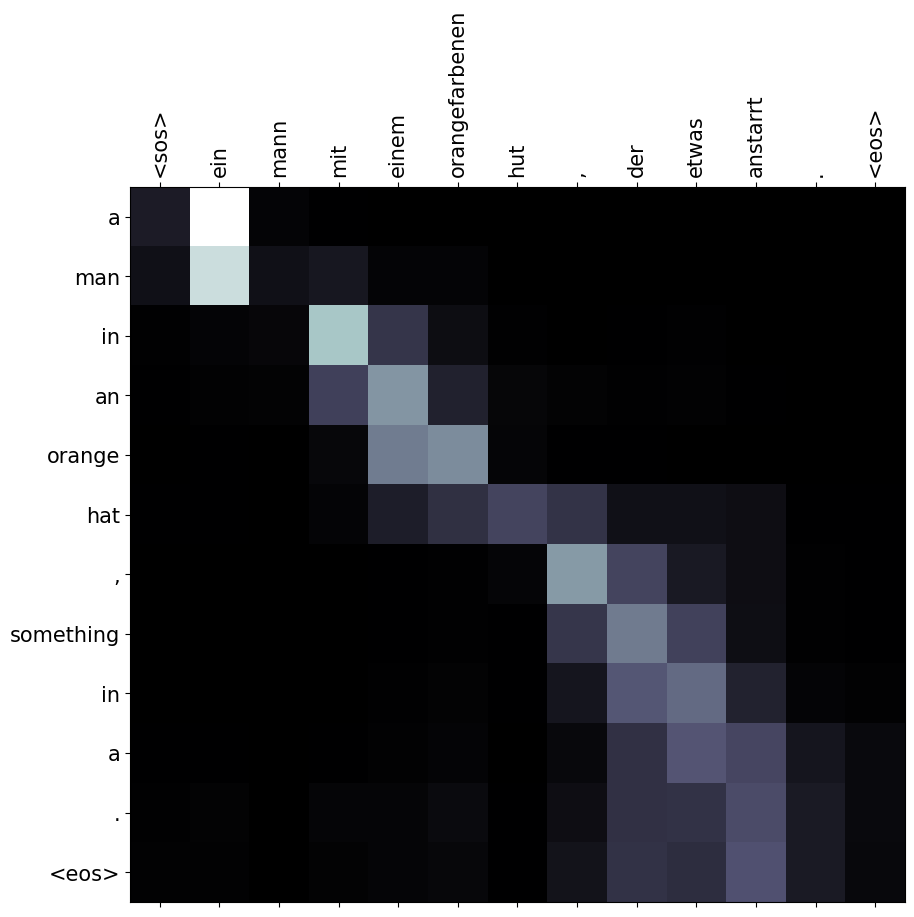

In [69]:
plot_attention(sentence_tokens, translation, attention)

In [51]:
sentence = "Ein Mann sieht sich einen Film an."

In [38]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

In [39]:
translation

['<sos>', 'a', 'man', 'watches', 'a', 'a', 'a', '.', '<eos>']

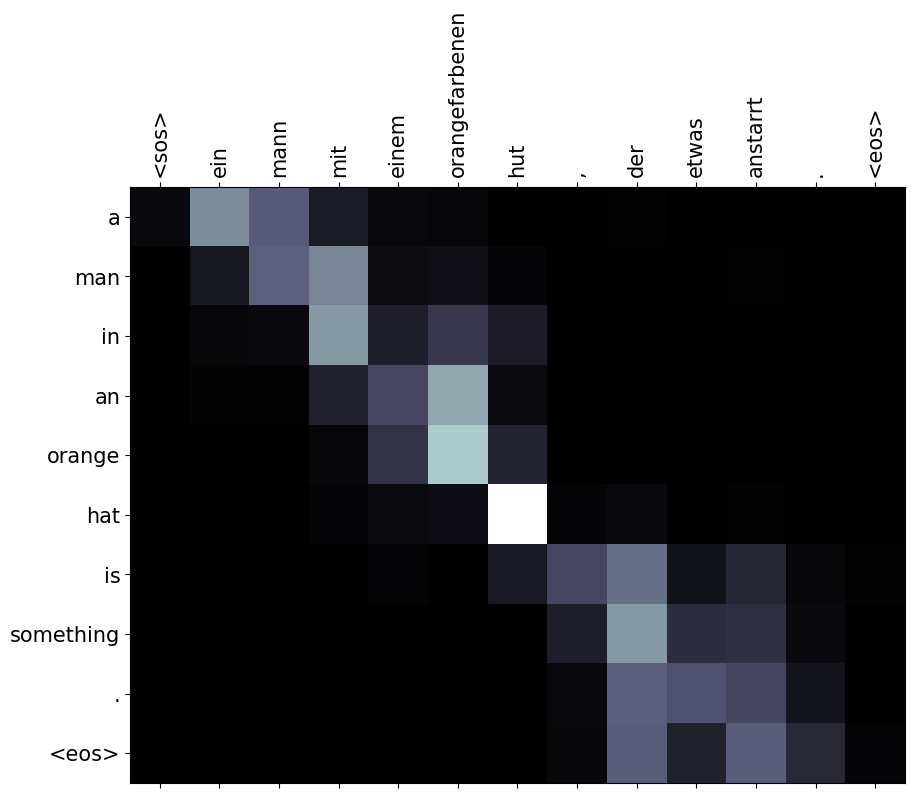

In [52]:
plot_attention(sentence_tokens, translation, attention)

In [70]:
translations = [
    translate_sentence(
        example["de"],
        model,
        en_nlp,
        de_nlp,
        en_vocab,
        de_vocab,
        lower,
        sos_token,
        eos_token,
        device,
    )[0]
    for example in tqdm.tqdm(test_data)
]

100%|██████████| 1000/1000 [00:21<00:00, 45.69it/s]


In [71]:
bleu = evaluate.load("bleu")

In [77]:
predictions = [" ".join(translation[1:-1]) for translation in translations]

references = [[example["en"]] for example in test_data]

In [81]:
len(predictions)

1000

In [80]:
len(references)

1000

In [73]:
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

In [74]:
tokenizer_fn = get_tokenizer_fn(en_nlp, lower)

In [78]:
results = bleu.compute(
    predictions=predictions, references=references, tokenizer=tokenizer_fn
)

In [79]:
results

{'bleu': 0.29524316707590686,
 'precisions': [0.6219354838709678,
  0.3709240246406571,
  0.22782997762863536,
  0.14457002457002457],
 'brevity_penalty': 1.0,
 'length_ratio': 1.00896002450605,
 'translation_length': 13175,
 'reference_length': 13058}